In [1]:
# import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
df_train = pd.read_csv("../data/train.csv", encoding="utf8")
df_test = pd.read_csv("../data/test.csv", encoding="utf8")

## EDA

In [3]:
train_id = df_train['Id']
test_id = df_test['Id']

df_train.drop(columns=["Id"], inplace=True)
df_test.drop(columns=["Id"], inplace=True)
print(df_train.shape, df_test.shape)


(1460, 80) (1459, 79)


In [4]:
df_train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1062,190,RM,85.000,13600,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2007,WD,Normal,90000
855,20,RL,nan,6897,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,127000
802,60,RL,63.000,8199,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,189000
1238,20,RL,63.000,13072,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2006,WD,Abnorml,142500
521,20,RL,90.000,11988,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,150000


In [5]:
df_test.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
368,30,RM,50.000,8635,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
227,60,RL,62.000,7984,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
1303,20,RL,86.000,11650,Pave,NaN,Reg,Lvl,AllPub,Corner,...,227,0,NaN,NaN,NaN,0,6,2006,WD,Normal
987,70,RM,53.000,9863,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml
569,120,FV,nan,4765,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


### 离群点分析 

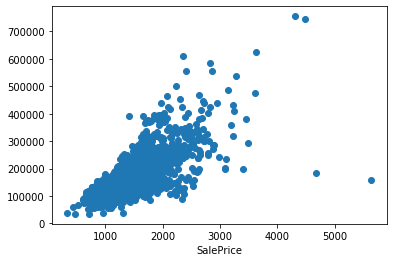

In [6]:
fig, ax = plt.subplots()
ax.scatter(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.xlabel('GrLivArea')
plt.xlabel('SalePrice')
plt.show()
# 该离群点可以删除是因为确实离群范围过大，严重影响模型拟合，不是所有的离群点都应该删除的 
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000)&(df_train['SalePrice']<300000)].index)

## 目标分析

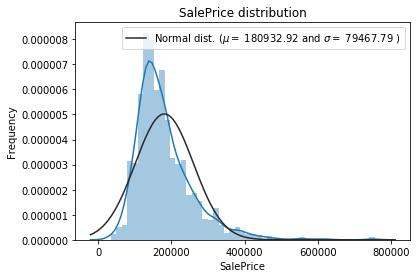

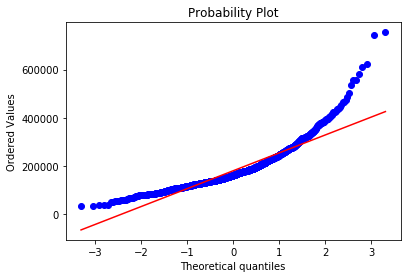

In [7]:
sns.distplot(df_train['SalePrice'], fit=norm)  # 使用正态分布拟合数据
(mu, sigma) = norm.fit(df_train['SalePrice'])  # 对样本进行拟合，得到最合适的采样数据的概率密度函数的系数
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(df_train['SalePrice'], plot=plt)
plt.show()

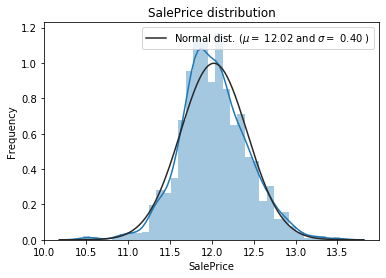

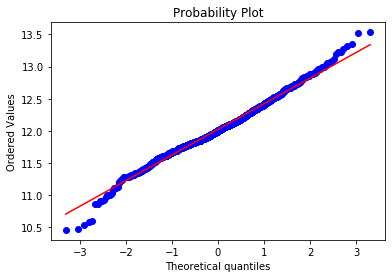

In [8]:
# 目标的分布是右偏的，而线性模型容易拟合正太分布数据，采用取对数使得数据更符合正态分布
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm)  # 使用正态分布拟合数据
(mu, sigma) = norm.fit(df_train['SalePrice'])  # 对样本进行拟合，得到最合适的采样数据的概率密度函数的系数
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(df_train['SalePrice'], plot=plt)  # 转换后几乎无偏
plt.show()

## 特征工程

In [9]:
# 为了方便空值处理，防止训练集非空属性出现在测试集，合并后进行空值处理
n_train, n_test = df_train.shape[0], df_train.shape[0]
y_train = df_train.SalePrice.values
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)  # 因为后面不会出现删除行，重置index即可
df_all.drop(columns=['SalePrice'], inplace=True)
df_all.shape

(2917, 79)

### 空值分析

In [10]:
all_data_null = df_all.isnull().sum() / len(df_all) * 100  # 统计各列的空值数目
all_data_null = all_data_null[all_data_null>0].sort_values(ascending=False)
miss_data = pd.DataFrame({'MissRatio': all_data_null})
miss_data.head(30)

,MissRatio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

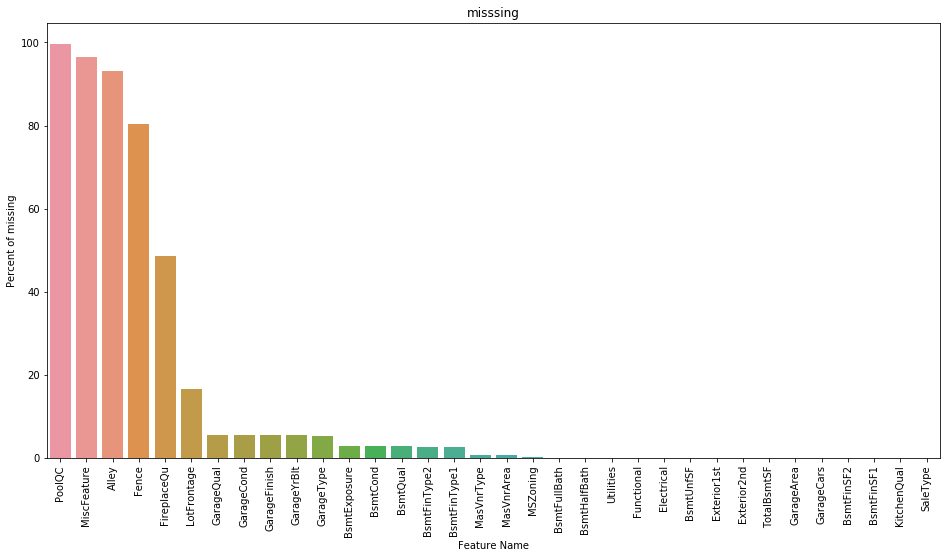

In [11]:
plt.figure(figsize=(16, 8))
sns.barplot(x=all_data_null.index, y=all_data_null)
plt.xlabel('Feature Name')
plt.ylabel('Percent of missing')
plt.title('misssing')
plt.xticks(rotation='90')

### 相关性分析

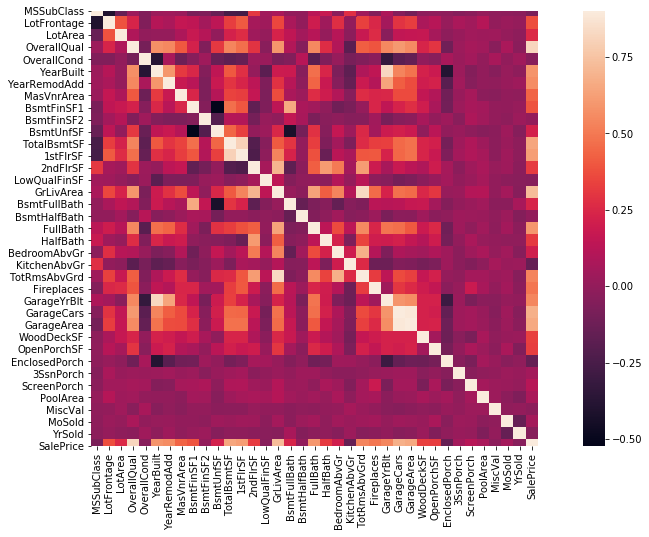

In [12]:
corr_mat = df_train.corr()
plt.subplots(figsize=(16, 8))
sns.heatmap(corr_mat, vmax=0.9, square=True)

### 空值处理

In [13]:
# 按照说明文件，PoolQC为空表示没有泳池，考虑到该列较高的缺失率以及大多数房子都是没有泳池的，直接None填充
df_all['PoolQC'] = df_all['PoolQC'].fillna("None")

In [14]:
# 下面几项均可以按照说明文件，直接填None
cols = ['MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in cols:
    df_all[col] = df_all[col].fillna("None")

In [15]:
# 街道面积与同社区的其他房屋的街道面积类似，取所有邻居中位数即可
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [16]:
# 根据属性含义，下面的属性直接填0
cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for col in cols:
    df_all[col] = df_all[col].fillna(0)

In [17]:
# 下面的属性为空表示无值
cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in cols:
    df_all[col] = df_all[col].fillna('None')

In [18]:
# 下面两个属性为NA最可能意味空值
df_all["MasVnrType"] = df_all["MasVnrType"].fillna("None")
df_all["MasVnrArea"] = df_all["MasVnrArea"].fillna(0)

In [19]:
# 众数填，RL最合适
df_all['MSZoning'] = df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])

In [20]:
# 该属性只有三个不同值，其余均为一个结果，该列对模型拟合没有太大意义，删除即可
df_all = df_all.drop(columns=['Utilities'], axis=1)

In [21]:
# 根据说明，Typ代表典型值
df_all["Functional"] = df_all["Functional"].fillna("Typ")

In [22]:
# 经过分析，下面的属性均众数填充即可
cols = ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in cols:
    df_all[col] = df_all[col].fillna(df_all[col].mode()[0])

In [23]:
# 填None
df_all['MSSubClass'] = df_all['MSSubClass'].fillna("None")

In [24]:
# 再次进行空值分析，查看填充效果，发现没有空值
all_data_null = df_all.isnull().sum() / len(df_all) * 100  # 统计各列的空值数目
all_data_null = all_data_null[all_data_null>0].sort_values(ascending=False)
miss_data = pd.DataFrame({'MissRatio': all_data_null})
miss_data.head(30)

,MissRatio


### 属性变换

In [25]:
# 部分看起来数值型的变量，其实取值只有几种，转换为分类变量合适一些
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

In [26]:
# 将部分分类变量转化为数值型
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_all[col].values)) 
    df_all[col] = lbl.transform(list(df_all[col].values))

# labelencoder不会像get_dummies那样生成多个属性
df_all.shape

(2917, 78)

### 属性构造

In [27]:
# 根据经验，面积对于房价的影响时非常大的，构造房屋总面积这个属性
df_all['TotalArea'] = df_all['TotalBsmtSF'] +  df_all['1stFlrSF'] + df_all['2ndFlrSF']

In [28]:
# 查看数值变量的偏度
numeric_cols = df_all.dtypes[df_all.dtypes != "object"].index

skewed_cols = df_all[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_cols})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [29]:
# 利用Box-Cox变换处理高偏特征
skewness = skewness[abs(skewness) > 0.75]
print("how many high skewed feature", skewness.shape)
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    df_all[feat] = boxcox1p(df_all[feat], lam)

how many high skewed feature (59, 1)


In [30]:
# 分类型特征通过pandas处理为onehot类型的多个特征
df_all = pd.get_dummies(df_all)
df_all.shape

(2917, 220)

In [32]:
# 分区训练测试集
train = df_all[:n_train]
test = df_all[n_train:]

## 模型构建

In [60]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb  # kaggle神器
import lightgbm as lgb  # kaggle神器

In [34]:
# 定义交叉验证rmse策略
n_folds = 5  # 5折
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=2019).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [36]:
# 基础模型尝试
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmse_cv(lasso)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1115 (0.0074)



In [37]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmse_cv(ENet)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1116 (0.0074)



In [38]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmse_cv(KRR)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1153 (0.0075)



In [61]:
ABR = AdaBoostRegressor()
score = rmse_cv(ABR)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1644 (0.0072)



In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmse_cv(GBoost)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1177 (0.0080)



In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmse_cv(model_xgb)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1165 (0.0072)



In [42]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf=11)
score = rmse_cv(model_lgb)
print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score: 0.1162 (0.0075)



In [43]:
# 定义一个类，平均模型的预测，这是比较简单的策略
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [44]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmse_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1091 (0.0075)



In [45]:
# 采用stacking方法
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [62]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, ABR), meta_model = lasso)
score = rmse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0075)


In [47]:
# 下面，组合这个stacked模型和xgb及lgb模型，结果加权组合
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [63]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
print(rmse(y_train, stacked_train_pred))
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))

0.07803870676554103


In [49]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmse(y_train, xgb_train_pred))

0.0794998911231869


In [50]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmse(y_train, lgb_train_pred))

0.07279273314127263


这样看，似乎LGB效果非常好，但是考虑到泛化能力，我们还是希望得到一个较为平均的结果

In [64]:
print("Final RMSE Loss in training dataset", rmse(y_train, stacked_train_pred*0.70+xgb_train_pred*0.15+lgb_train_pred*0.15))

Final RMSE Loss in training dataset 0.07550023832795065


In [65]:
ensemble_pred = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [66]:
df_submit = pd.DataFrame({'Id': test_id, 'SalePrice': ensemble_pred})
df_submit.to_csv('../data/submit_final.csv', index=False)